In [268]:
import parametrization as param
from CentralStreamingModel.utils.read_probabilities import VD, VD_los
from CentralStreamingModel.projection import generating_moments
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simps
from scipy.interpolate import interp1d, interp2d
import seaborn as sns
from CentralStreamingModel.moments import moments2model, read
from scipy.interpolate import UnivariateSpline
from halotools.mock_observables import tpcf_multipole
from scipy.special import legendre
import sympy as sym

sns.set_context('talk')

In [2]:
n_boxes = 5
boxsize = 1024
snapshot = 0
rm = read.Read_Mean(n_boxes, boxsize, snapshot)

In [3]:
# Set correlation function to zero
rm.tpcf_dict['tpcf'] = np.zeros_like(rm.tpcf_dict['tpcf'])

In [4]:
parameters = [r'$m_r$',r'$c_r$',r'$c_t$']

In [5]:
ex = generating_moments.Expectations(rm.r, rm.v_r, rm.v_t,
                                     rm.jointpdf_rt)


In [220]:
s = np.arange(0.,50.,1)
mu = np.linspace(0.,1,60)


In [7]:
moments_projected = generating_moments.project(ex, rm.r_perp,
                                    rm.r_parallel)

In [8]:
gaussian = moments2model.Model(rm, moments_projected, model='gaussian')


In [9]:
gaussian.multipoles(s, mu) 

In [10]:
m_r = ex.moment(1,0)(rm.r)
c_r = ex.central_moment(2,0)(rm.r)
c_t = ex.central_moment(0,2)(rm.r)

c_3 = ex.moment(3,0)(rm.r)

In [11]:
measured = moments2model.Model(rm, moments_projected, 'measured')

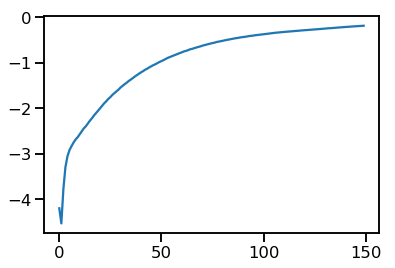

In [12]:
plt.plot(m_r, label='radial')


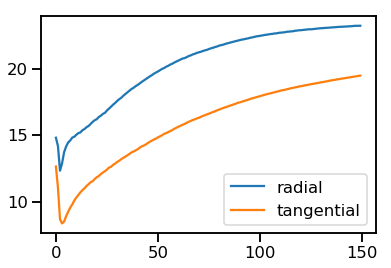

In [13]:
plt.plot(c_r, label='radial')
plt.plot(c_t, label='tangential')
plt.legend()

## FIT THE LOWEST THREE MOMENTS

In [14]:
def fitting_m_r(r, a,c,d):
    return a * r**(0.5) + c*r + d

In [15]:
def fitting_m_r(r, a, b):
    return a * r + b

34.81593964264188


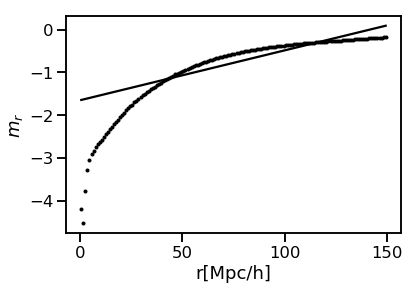

In [16]:
idx = 0

_, chi, popt_m_r = param.plot(fitting_m_r, rm.r, m_r, 
        'black', 'Halos',parameters[idx], limit = 20)
#plt.text(40, -2, r'$\chi^2_\nu $ = %.2f'%chi, fontdict=dict(color='black'))
#plt.text(40,-2,r'$m_r(r) = A \sqrt{r} + B r + C$')

In [349]:
def fitting_c(r):
    return 4.

## GENERATE GAUSSIAN STREAMING MODEL WITH FITTED MOMENTS

In [350]:

moments_reduced = np.zeros((len(rm.r_perp), len(rm.r_parallel), 2))


for i, rper in enumerate(rm.r_perp):                                                                                                   
    for j, rpar in enumerate(rm.r_parallel):                                                                                           

        r_ = np.sqrt(rper**2 + rpar**2)                                                                                             
        mu_value = rpar/r_                                                                                                                


        moments_reduced[i,j, 0] = fitting_m_r(r_, *popt_m_r) * mu_value                                                                                  

        moments_reduced[i,j, 1] = fitting_c(r_) * mu_value**2 \
                            + fitting_c(r_) * (1 - mu_value**2) 



In [351]:
gaussian_reduced = moments2model.Model(rm, moments_reduced, model = 'gaussian')

In [352]:
gaussian_reduced.multipoles(s, mu) 

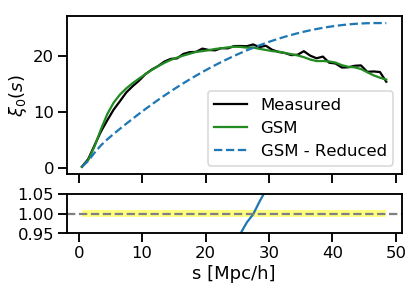

In [353]:
fig, (ax1, ax2) = plt.subplots(nrows=2,sharex = True, squeeze = True,
                          gridspec_kw = {'height_ratios':[4,1]})

ax1.plot(measured.s_c, measured.s_c * measured.s_c * measured.mono,
        color = 'black', label = 'Measured')

ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * gaussian.mono,
        color = 'forestgreen', label = 'GSM')
ax1.plot(gaussian_reduced.s_c, 
         gaussian_reduced.s_c * gaussian_reduced.s_c * gaussian_reduced.mono,
        label = 'GSM - Reduced', linestyle='dashed')


ax2.plot(gaussian_reduced.s_c[1:], gaussian_reduced.mono[1:]/gaussian.mono[1:])
ax2.axhline(y = 1., linestyle='dashed', color='gray')
ax1.set_ylabel(r'$\xi_0 (s)$')
ax2.set_xlabel(r's [Mpc/h]')
ax2.fill_between(gaussian.s_c,0.99, 1.01, facecolor = 'yellow', alpha = 0.5)
ax2.set_ylim(0.95,1.05)
ax1.legend()


Text(0.5,0,'s [Mpc/h]')

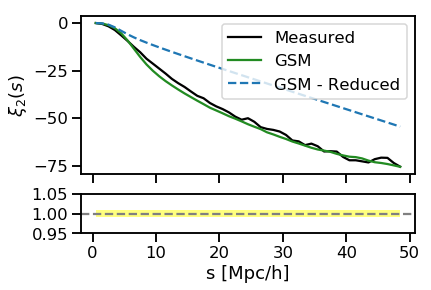

In [354]:
fig, (ax1, ax2) = plt.subplots(nrows=2,sharex = True, squeeze = True,
                          gridspec_kw = {'height_ratios':[4,1]})

ax1.plot(measured.s_c, measured.s_c * measured.s_c * measured.quad,
        color = 'black', label = 'Measured')

ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * gaussian.quad,
         color = 'forestgreen', label = 'GSM')
ax1.plot(gaussian_reduced.s_c, gaussian_reduced.s_c * gaussian_reduced.s_c * gaussian_reduced.quad,
                label = 'GSM - Reduced', linestyle='dashed')

ax1.legend()
ax2.plot(gaussian_reduced.s_c[1:], gaussian_reduced.quad[1:]/gaussian.quad[1:])
ax2.axhline(y = 1., linestyle='dashed', color='gray')
ax2.fill_between(gaussian.s_c,0.99, 1.01, facecolor = 'yellow', alpha = 0.5)
ax2.set_ylim(0.95,1.05)

ax1.set_ylabel(r'$\xi_2 (s)$')
ax2.set_xlabel(r's [Mpc/h]')

Text(0.5,0,'s [Mpc/h]')

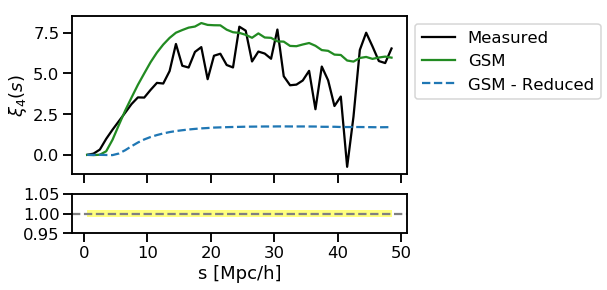

In [355]:
fig, (ax1, ax2) = plt.subplots(nrows=2,sharex = True, squeeze = True,
                          gridspec_kw = {'height_ratios':[4,1]})

ax1.plot(measured.s_c, measured.s_c * measured.s_c * measured.hexa,
        color = 'black', label = 'Measured')
ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * gaussian.hexa,
         color = 'forestgreen', label = 'GSM')
ax1.plot(gaussian_reduced.s_c, gaussian_reduced.s_c * gaussian_reduced.s_c * gaussian_reduced.hexa,
                label = 'GSM - Reduced', linestyle='dashed')

ax1.legend(bbox_to_anchor=(1,1))

ax2.plot(gaussian_reduced.s_c[1:], gaussian_reduced.hexa[1:]/gaussian.hexa[1:])
ax2.axhline(y = 1., linestyle='dashed', color='gray')
ax2.fill_between(gaussian.s_c,0.99, 1.01, facecolor = 'yellow', alpha = 0.5)
ax2.set_ylim(0.95,1.05)

ax1.set_ylabel(r'$\xi_4 (s)$')
ax2.set_xlabel(r's [Mpc/h]')

## TAYLOR EXPANSION

In [358]:
def first_mu_prime(s, mu):
    return (1 - mu**2)/s


def first_m1_dot(s, popt_m_r):
    a,b = popt_m_r
    return a

def first_m1_prime(s, mu, popt_m_r):
    
    return first_mu_prime(s,mu) * fitting_m_r(s, *popt_m_r) + \
            mu**2 * first_m1_dot(s, popt_m_r)

In [359]:
def second_mu_prime(s, mu):
    return -3 * (1-mu**2)*mu/s**2
    
def second_s_prime(s,mu):
    return (1 - mu**2)/s

def second_m1_dot(s, popt_m_r):
    return 0.

def second_m1_prime(s, mu, popt_m_r):
    return second_mu_prime(s, mu) * fitting_m_r(s, *popt_m_r)  + \
            2 * first_mu_prime(s, mu) * mu * first_m1_dot(s, popt_m_r) + \
            mu * (second_s_prime(s, mu) * first_m1_dot(s, popt_m_r) + \
                  mu**2 * second_m1_dot(s, popt_m_r))

In [360]:
def first_dot_c(s):

    return 0.
    
def second_dot_c(s):

    return 0.

def second_c2_prime(s, mu):

    
    return (fitting_c(s,) - fitting_c(s,))* (2 * first_mu_prime(s, mu)**2 \
                                                                 + 2 * mu *second_mu_prime(s,mu)) + \
            (first_dot_c(s) - first_dot_c(s)) * 4 *mu**2 * first_mu_prime(s, mu) + \
            mu**2 * (second_s_prime(s,mu) *first_dot_c(s) + mu**2 * second_dot_c(s) ) +\
            (1-mu**2) * (second_s_prime(s,mu) *first_dot_c(s) + mu**2 * second_dot_c(s) )
            

In [361]:
def second_m2_prime(s, mu, popt_m_r):
        
    return second_c2_prime(s, mu) + \
            2 * first_m1_prime(s, mu, popt_m_r)**2 + \
            2 *  mu * fitting_m_r(s, *popt_m_r) * second_m1_prime(s, mu, popt_m_r)

In [362]:
def legendre(mu, multipole_order):
    
    if multipole_order == 0:
        return 1
    
    elif multipole_order == 2:
        return 1./2. * (3 * mu**2 - 1)
    
    elif multipole_order == 4:
        return 1./8. * (35 *mu**4 - 30 *  mu**2 + 3)
    
    else:    
        raise ValueError('Multipole order not implemented.')    
    
def s_mu_approximation(mu, s, order):
    
    approx = -first_m1_prime(s, mu, popt_m_r)
    
    if order == 2:
        approx +=  0.5 * second_m2_prime(s, mu, popt_m_r)
        
    return approx


def multipoles_approximation(mu, s, order, multipole_order):
    
     return (2 * multipole_order + 1)/2. * \
                s_mu_approximation(mu, s, order) * legendre(mu, multipole_order)
        

In [363]:
def approximation(order):
    
    x = sym.Symbol('x')

    s_c = 0.5* (s[1:] + s[:-1])
    
    mono_approx = np.zeros((len(s_c)))
    quad_approx = np.zeros((len(s_c)))
    hexa_approx = np.zeros((len(s_c)))

    for i, s_value in enumerate(s_c):
        mono_approx[i] = sym.integrate(multipoles_approximation(x, s_value, order, 0), (x, -1, 1))
        quad_approx[i] = sym.integrate(multipoles_approximation(x, s_value, order, 2), (x, -1, 1))
        hexa_approx[i] = sym.integrate(multipoles_approximation(x, s_value, order, 4), (x, -1, 1))

    return mono_approx, quad_approx, hexa_approx
    

In [364]:
mono_1, quad_1, hexa_1 = approximation(1)
mono_2, quad_2, hexa_2 = approximation(2)

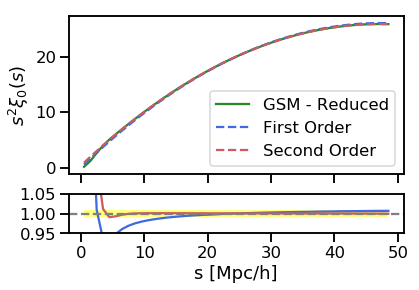

In [365]:
fig, (ax1, ax2) = plt.subplots(nrows=2,sharex = True, squeeze = True,
                          gridspec_kw = {'height_ratios':[4,1]})

ax1.plot(gaussian_reduced.s_c, 
         gaussian_reduced.s_c * gaussian_reduced.s_c * gaussian_reduced.mono, 
         label = 'GSM - Reduced', color='forestgreen')
ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * mono_1, 
         label = 'First Order', linestyle='dashed', color = 'royalblue')
ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * mono_2,
         label = 'Second Order', linestyle='dashed', color = 'indianred')


ax2.plot(gaussian_reduced.s_c[1:], 
         mono_1[1:]/gaussian_reduced.mono[1:],
         color = 'royalblue')
ax2.plot(gaussian_reduced.s_c[1:],
         mono_2[1:]/gaussian_reduced.mono[1:], 
        color = 'indianred')



ax2.axhline(y = 1., linestyle='dashed', color='gray')
ax1.set_ylabel(r'$s^2 \xi_0 (s)$')
ax2.set_xlabel(r's [Mpc/h]')
ax2.fill_between(gaussian.s_c,0.99, 1.01, facecolor = 'yellow', alpha = 0.5)
ax2.set_ylim(0.95,1.05)

ax1.legend()

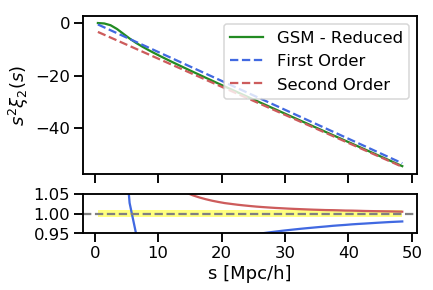

In [366]:
fig, (ax1, ax2) = plt.subplots(nrows=2,sharex = True, squeeze = True,
                          gridspec_kw = {'height_ratios':[4,1]})

ax1.plot(gaussian_reduced.s_c, 
         gaussian_reduced.s_c * gaussian_reduced.s_c * gaussian_reduced.quad, 
         label = 'GSM - Reduced', color='forestgreen')
ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * quad_1, 
         label = 'First Order', linestyle='dashed', color = 'royalblue')
ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * quad_2,
         label = 'Second Order', linestyle='dashed', color = 'indianred')


ax2.plot(gaussian_reduced.s_c[1:], 
         quad_1[1:]/gaussian_reduced.quad[1:],
         color = 'royalblue')
ax2.plot(gaussian_reduced.s_c[1:],
        quad_2[1:]/gaussian_reduced.quad[1:], 
        color = 'indianred')



ax2.axhline(y = 1., linestyle='dashed', color='gray')
ax1.set_ylabel(r'$s^2 \xi_2 (s)$')
ax2.set_xlabel(r's [Mpc/h]')
ax2.fill_between(gaussian.s_c,0.99, 1.01, facecolor = 'yellow', alpha = 0.5)
ax2.set_ylim(0.95,1.05)

ax1.legend()

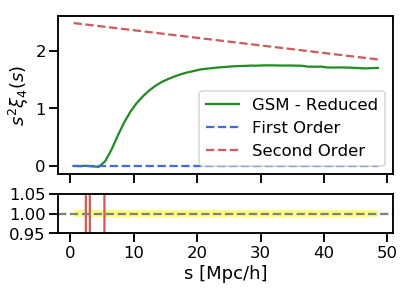

In [367]:
fig, (ax1, ax2) = plt.subplots(nrows=2,sharex = True, squeeze = True,
                          gridspec_kw = {'height_ratios':[4,1]})

ax1.plot(gaussian_reduced.s_c, 
         gaussian_reduced.s_c * gaussian_reduced.s_c * gaussian_reduced.hexa, 
         label = 'GSM - Reduced', color='forestgreen')
ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * hexa_1, 
         label = 'First Order', linestyle='dashed', color = 'royalblue')
ax1.plot(gaussian.s_c, gaussian.s_c * gaussian.s_c * hexa_2,
         label = 'Second Order', linestyle='dashed', color = 'indianred')


ax2.plot(gaussian_reduced.s_c[1:], 
         hexa_1[1:]/gaussian_reduced.hexa[1:],
         color = 'royalblue')
ax2.plot(gaussian_reduced.s_c[1:],
        hexa_2[1:]/gaussian_reduced.hexa[1:], 
        color = 'indianred')



ax2.axhline(y = 1., linestyle='dashed', color='gray')
ax1.set_ylabel(r'$s^2 \xi_4 (s)$')
ax2.set_xlabel(r's [Mpc/h]')
ax2.fill_between(gaussian.s_c,0.99, 1.01, facecolor = 'yellow', alpha = 0.5)
ax2.set_ylim(0.95,1.05)

ax1.legend()